# Fine tuning of Support Vector Classifier with RBF kernel

## for binary classification with independent datapoints

In [148]:
from pathlib import Path
# import json
import pandas as pd
import numpy as np

# pipeline utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import (
    make_scorer, average_precision_score, classification_report,
    ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
)

# models
from sklearn.svm import SVC

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# get train and test datasets
# if missing then run 'make inputs'
input_dir = '../data/processed/binary_independent'
X_train = pd.read_pickle(Path(f'{input_dir}/X_train.pkl').resolve())
X_test = pd.read_pickle(Path(f'{input_dir}/X_test.pkl').resolve())
y_train = pd.read_pickle(Path(f'{input_dir}/y_train.pkl').resolve())
y_test = pd.read_pickle(Path(f'{input_dir}/y_test.pkl').resolve())

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8103, 10)
(2026, 10)
(8103,)
(2026,)


In [44]:
# numeric features that need transformation
real_features = ['mintemp', 'maxtemp', 'minlight', 'maxlight', 'minsound', 'maxsound', 'co2', 'co2slope']

# scorer: Area under Precision-Recall curve (PR-AUC)
scorer = make_scorer(score_func=average_precision_score)

# 10x Repeated 5-fold cross-validation
kf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
# kf = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=42)

### Tuning without PCA

In [114]:
def get_search_results(X_train, y_train, param_grid: dict) -> dict:
    
    model = SVC(kernel='rbf', random_state=42)

    numTransformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numTransformer, real_features),
        ]
    )

    estimator = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )

    search = HalvingGridSearchCV(estimator, param_grid, factor=2, cv=kf, scoring=scorer, refit=True, verbose=1)
    search.fit(X_train, y_train)
        
    return search

In [117]:
def report_results(results: dict) -> None:
    
    # print best parameter combination
    print(f'Best parameters:\n{results.best_params_}\n')
    # print best score
    print(f'Best score:\n{results.best_score_}\n')
    
    # plot heatmap
    df = pd.DataFrame(results.cv_results_)
    df = df.drop_duplicates(subset=['param_model__C', 'param_model__gamma'], keep='last')
    df['rank'] = df['mean_test_score'].rank(method='min', ascending=False)

    data = df.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
    annot = df.pivot(index='param_model__C', columns='param_model__gamma', values='rank')
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(data, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=annot)
    plt.show()

In [96]:
param_grid = {
    'model__C': np.logspace(1, 5, num=5),
    'model__gamma': np.linspace(3.5, 5.0, 16)
}

search = get_search_results(X_train, y_train, param_grid)
search

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 200
Fitting 50 folds for each of 80 candidates, totalling 4000 fits
----------
iter: 1
n_candidates: 40
n_resources: 400
Fitting 50 folds for each of 40 candidates, totalling 2000 fits
----------
iter: 2
n_candidates: 20
n_resources: 800
Fitting 50 folds for each of 20 candidates, totalling 1000 fits
----------
iter: 3
n_candidates: 10
n_resources: 1600
Fitting 50 folds for each of 10 candidates, totalling 500 fits
----------
iter: 4
n_candidates: 5
n_resources: 3200
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 5
n_candidates: 3
n_resources: 6400
Fitting 50 folds for each of 3 candidates, totalling 150 fits


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,params,split0_test_score,...,split42_train_score,split43_train_score,split44_train_score,split45_train_score,split46_train_score,split47_train_score,split48_train_score,split49_train_score,mean_train_score,std_train_score
0,0,200,0.016787,0.009957,0.009220,0.005544,10.0,3.5,"{'model__C': 10.0, 'model__gamma': 3.5}",1.0,...,1.00000,1.0,0.982994,1.0,1.0,1.0,1.000000,1.0,0.998504,0.006090
1,0,200,0.010741,0.003509,0.006260,0.002660,10.0,3.6,"{'model__C': 10.0, 'model__gamma': 3.6}",1.0,...,1.00000,1.0,0.982994,1.0,1.0,1.0,1.000000,1.0,0.998504,0.006090
2,0,200,0.009762,0.001934,0.005339,0.001863,10.0,3.7,"{'model__C': 10.0, 'model__gamma': 3.7}",1.0,...,1.00000,1.0,0.982994,1.0,1.0,1.0,1.000000,1.0,0.998504,0.006090
3,0,200,0.010061,0.004549,0.006819,0.006520,10.0,3.8,"{'model__C': 10.0, 'model__gamma': 3.8}",1.0,...,1.00000,1.0,0.982994,1.0,1.0,1.0,1.000000,1.0,0.998504,0.006090
4,0,200,0.011701,0.003930,0.007380,0.004582,10.0,3.9,"{'model__C': 10.0, 'model__gamma': 3.9}",1.0,...,1.00000,1.0,0.982994,1.0,1.0,1.0,1.000000,1.0,0.998504,0.006090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,4,3200,0.030295,0.005324,0.012439,0.002858,100.0,4.1,"{'model__C': 100.0, 'model__gamma': 4.1}",1.0,...,1.00000,1.0,1.000000,1.0,1.0,1.0,0.998379,1.0,0.999765,0.000583
154,4,3200,0.029738,0.007980,0.012201,0.003754,100.0,3.9,"{'model__C': 100.0, 'model__gamma': 3.9}",1.0,...,1.00000,1.0,1.000000,1.0,1.0,1.0,0.998379,1.0,0.999693,0.000657
155,5,6400,0.065862,0.020829,0.021959,0.008543,10000.0,4.1,"{'model__C': 10000.0, 'model__gamma': 4.1}",1.0,...,1.00000,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.000000,0.000000
156,5,6400,0.070242,0.028617,0.026366,0.015316,100.0,4.1,"{'model__C': 100.0, 'model__gamma': 4.1}",1.0,...,0.99913,1.0,1.000000,1.0,1.0,1.0,0.999153,1.0,0.999898,0.000277


Best parameters:
{'model__C': 100.0, 'model__gamma': 4.1}

Best parameters:
0.997102897717467



C:\Users\Judit\AppData\Local\Temp\ipykernel_10556\1260358560.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_10556\1260358560.py:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


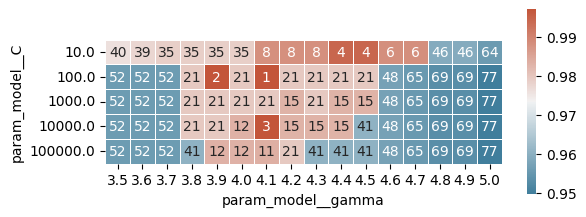

In [111]:
report_results(search)

### Fine-tuning for the most promising region (C: 100-10,000; gamma: 3.8-4.2)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 96
n_resources: 200
Fitting 50 folds for each of 96 candidates, totalling 4800 fits
----------
iter: 1
n_candidates: 48
n_resources: 400
Fitting 50 folds for each of 48 candidates, totalling 2400 fits
----------
iter: 2
n_candidates: 24
n_resources: 800
Fitting 50 folds for each of 24 candidates, totalling 1200 fits
----------
iter: 3
n_candidates: 12
n_resources: 1600
Fitting 50 folds for each of 12 candidates, totalling 600 fits
----------
iter: 4
n_candidates: 6
n_resources: 3200
Fitting 50 folds for each of 6 candidates, totalling 300 fits
----------
iter: 5
n_candidates: 3
n_resources: 6400
Fitting 50 folds for each of 3 candidates, totalling 150 fits
Best parameters:
{'model__C': 630.957344480193, 'model__gamma': 4.013333333333334}

Best parameters:
0.9969896306856828



C:\Users\Judit\AppData\Local\Temp\ipykernel_10556\1260358560.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_10556\1260358560.py:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


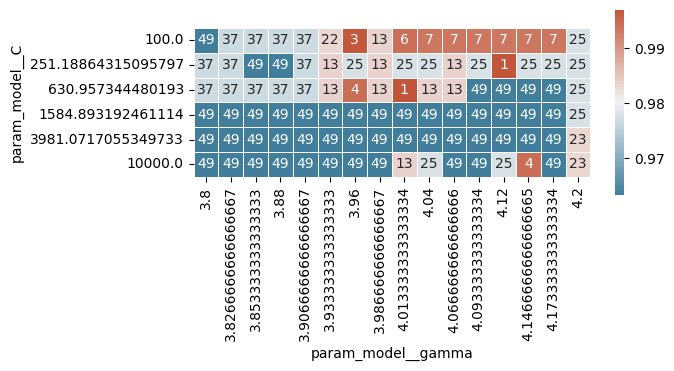

In [116]:
param_grid = {
    'model__C': np.logspace(2, 4, num=6),
    'model__gamma': np.linspace(3.8, 4.2, 16)
}

results = get_search_results(X_train, y_train, param_grid)
report_results(results)

### Fine-tuning for the most promising region (C: 100-800; gamma: 3.8-4.2)

In [124]:
param_grid = {
    'model__C': np.linspace(100, 800, num=8),
    'model__gamma': np.linspace(3.8, 4.2, 9)
}

results = get_search_results(X_train, y_train, param_grid)

n_iterations: 6
n_required_iterations: 7
n_possible_iterations: 6
min_resources_: 200
max_resources_: 8103
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 200
Fitting 50 folds for each of 72 candidates, totalling 3600 fits
----------
iter: 1
n_candidates: 36
n_resources: 400
Fitting 50 folds for each of 36 candidates, totalling 1800 fits
----------
iter: 2
n_candidates: 18
n_resources: 800
Fitting 50 folds for each of 18 candidates, totalling 900 fits
----------
iter: 3
n_candidates: 9
n_resources: 1600
Fitting 50 folds for each of 9 candidates, totalling 450 fits
----------
iter: 4
n_candidates: 5
n_resources: 3200
Fitting 50 folds for each of 5 candidates, totalling 250 fits
----------
iter: 5
n_candidates: 3
n_resources: 6400
Fitting 50 folds for each of 3 candidates, totalling 150 fits


Best parameters:
{'model__C': 300.0, 'model__gamma': 4.0}

Best score:
0.9971734042955431



C:\Users\Judit\AppData\Local\Temp\ipykernel_10556\2947654146.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  data = df.pivot(index='param_model__C', columns='param_model__gamma', values='mean_test_score')
C:\Users\Judit\AppData\Local\Temp\ipykernel_10556\2947654146.py:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annot = df.pivot(index='param_model__C', columns='param_model__gamma', values='rank')


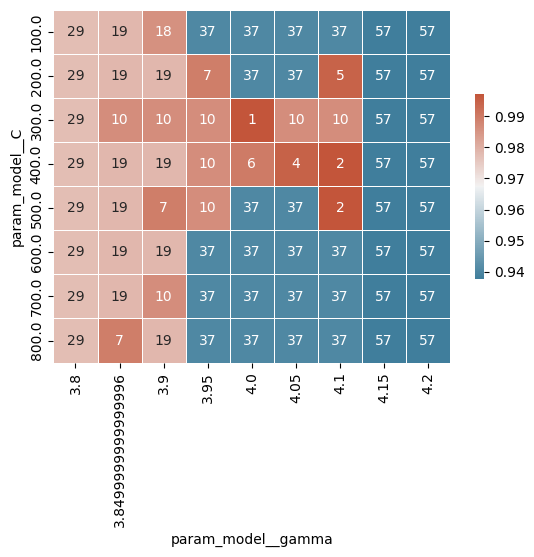

In [125]:
report_results(results)

## Best model cross-validation performance

In [161]:
scores = pd.DataFrame(results.cv_results_).filter(regex='split\d{1,2}_test', axis=1).iloc[results.best_index_, :].to_list()
mean = np.mean(scores)
median = np.median(scores)
lower = max(0.0, np.percentile(scores, 2.5))
upper = min(1.0, np.percentile(scores, 97.5))
print(f"Mean: {mean:.4f}")
print(f"Median: {median:.4f}")
print(f"95% confidence interval: ({lower:.4f} - {upper:.4f})")

Mean: 0.9972
Median: 1.0000
95% confidence interval: (0.9884 - 1.0000)


## Evaluate best model on hold-out test dataset

In [135]:
y_pred = results.best_estimator_.predict(X_test)

In [146]:
# Classification report
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      1646
           1     1.0000    0.9974    0.9987       380

    accuracy                         0.9995      2026
   macro avg     0.9997    0.9987    0.9992      2026
weighted avg     0.9995    0.9995    0.9995      2026



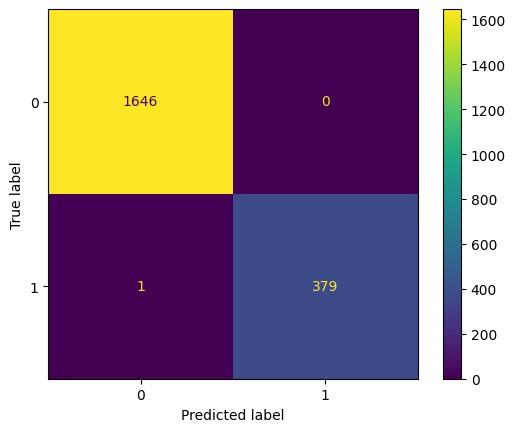

In [132]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

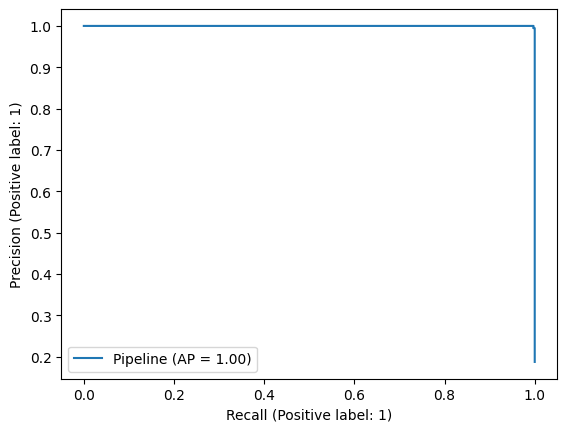

In [136]:
# Precision - Recall curve
PrecisionRecallDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()

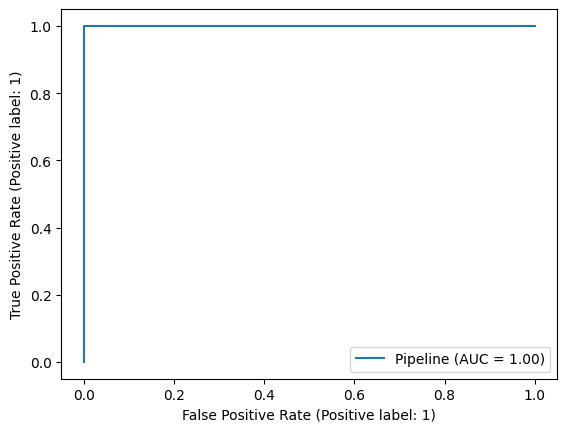

In [138]:
# ROC curve
RocCurveDisplay.from_estimator(results.best_estimator_, X_test, y_test)
plt.show()